In [1]:
%load_ext autoreload

%autoreload 2
import matplotlib.pyplot as plt
import pickle
import sys
from astropy.table import QTable, Table, vstack, join 
import numpy as np
from astropy.cosmology import FlatLambdaCDM
import astropy.units as u
from astropy.table import Table, QTable
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_3d
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
import iminuit
from iminuit import Minuit
cosmo_astropy.critical_density(0.4).to(u.Msun / u.Mpc**3).value

#module from my personnal github
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_WL_miscentering as mis
import CL_WL_DATAOPS_make_profile as prf
import CL_WL_two_halo_term as twoh
import CL_WL_mass_conversion as utils
import CL_WL_fit_cluster_mass as fit
import CL_Mass_richness_relation as mr

import clmm
import clmm.dataops
from clmm.dataops import compute_tangential_and_cross_components, make_radial_profile, make_bins
from clmm.galaxycluster import GalaxyCluster
import clmm.utils as u
from clmm import Cosmology
from clmm.support import mock_data as mock
import pyccl as ccl
cosmo = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_astropy = FlatLambdaCDM(H0=71.0, Om0=0.265, Ob0 = 0.0448)
cosmo_clmm = Cosmology(H0 = 71.0, Omega_dm0 = 0.265 - 0.0448, Omega_b0 = 0.0448, Omega_k0 = 0.0)
cosmo_ccl  = ccl.Cosmology(Omega_c=0.265-0.0448, Omega_b=0.0448, h=0.71, A_s=2.1e-9, n_s=0.96, Neff=0, Omega_g=0)

In [2]:
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
down, up, n_bins = 0.1 , 15,40
bin_edges = make_bins(down, up, nbins=n_bins, method='evenlog10width')
radial_bin = binning(bin_edges)

In [3]:
radial_bin_mid = np.mean(radial_bin, axis = 1)

In [4]:
radial_bin_mid

array([ 0.10667249,  0.12090791,  0.13704304,  0.15533141,  0.17606035,
        0.19955556,  0.22618621,  0.25637071,  0.29058332,  0.3293616 ,
        0.37331483,  0.42313361,  0.4796007 ,  0.5436033 ,  0.61614704,
        0.69837173,  0.79156928,  0.89720402,  1.0169357 ,  1.15264555,
        1.30646584,  1.48081341,  1.67842763,  1.90241343,  2.15629007,
        2.4440465 ,  2.77020396,  3.13988707,  3.5589043 ,  4.03383928,
        4.57215424,  5.1823072 ,  5.87388494,  6.65775358,  7.54622931,
        8.55327193,  9.69470417, 10.98846028, 12.45486786, 14.1169672 ])

In [5]:

def load(filename, **kwargs):

    with open(filename, 'rb') as fin:
        
        return pickle.load(fin, **kwargs)

In [6]:
profile_cosmodc2 = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_DC2_validation/cosmoDC2/cosmodc2_true_shape_all_bins_ns.pkl')
profile_SkySim5000 = load('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/p_DC2_validation/SkySim5000/SkySim5000_true_shape_all_bins_ns.pkl')

In [7]:
len(profile_SkySim5000), len(profile_cosmodc2)

(4725, 5906)

In [8]:
m_SORT = np.sort(np.array(profile_cosmodc2['M200c']), axis = 0)
m_list = np.array_split(m_SORT,5)

m_corner = []
for m_ in m_list[1:]:
    m_corner.append(m_[0][0])
m_corner.append(np.inf)

In [9]:
z_corner = np.linspace(0.2, 1 , 9)
Z_bin = binning(z_corner)
m_corner = np.logspace(14,14.5, 3)
#m_corner = np.linspace(1e14, 1e15, 7)
Mass_bin = binning(m_corner)
print(Z_bin), print(np.log10(Mass_bin))

[[0.2, 0.30000000000000004], [0.30000000000000004, 0.4], [0.4, 0.5], [0.5, 0.6000000000000001], [0.6000000000000001, 0.7], [0.7, 0.8], [0.8, 0.9000000000000001], [0.9000000000000001, 1.0]]
[[14.   14.25]
 [14.25 14.5 ]]


(None, None)

In [10]:
profile_stack_cosmodc2 = prf.stacked_profile(profile = profile_cosmodc2,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

covariance_stack_cosmodc2 = prf.bootstrap_covariance(profile = profile_cosmodc2,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    n_boot = 100,
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

/pbs/home/c/cpayerne/.conda/envs/mydesc/lib/python3.7/site-packages/numpy/ma/core.py:2832: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  order=order, subok=True, ndmin=ndmin)


In [11]:
profile_stack_sky = prf.stacked_profile(profile = profile_SkySim5000,
                    r_in = 'radius_av',
                    gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'norm_sum',
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

covariance_stack_sky = prf.bootstrap_covariance(profile = profile_SkySim5000,
                    r_in = 'radius_av',
                                        gt_in = 'gt_av', gx_in = 'gx_av',
                    r_out = 'radius',
                    gt_out = 'gt', gx_out = 'gx',
                    weight = 'M200c',
                    n_boot = 200,
                    z_name = 'cluster_z', obs_name = 'M200c',
                    Z_bin = Z_bin, Obs_bin = Mass_bin)

/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_WL_DATAOPS_make_profile.py:35: RuntimeWarning: invalid value encountered in double_scalars
  return gt_w/w, gx_w/w, r_w/w
/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/CL_WL_DATAOPS_make_profile.py:35: RuntimeWarning: invalid value encountered in true_divide
  return gt_w/w, gx_w/w, r_w/w


In [12]:
moo = clmm.Modeling(massdef = 'critical', delta_mdef = 200, halo_profile_model = 'nfw')
moo.set_cosmo(cosmo_clmm)
deff = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
conc = ccl.halos.concentration.ConcentrationDiemer15(mdef=deff)

4 1


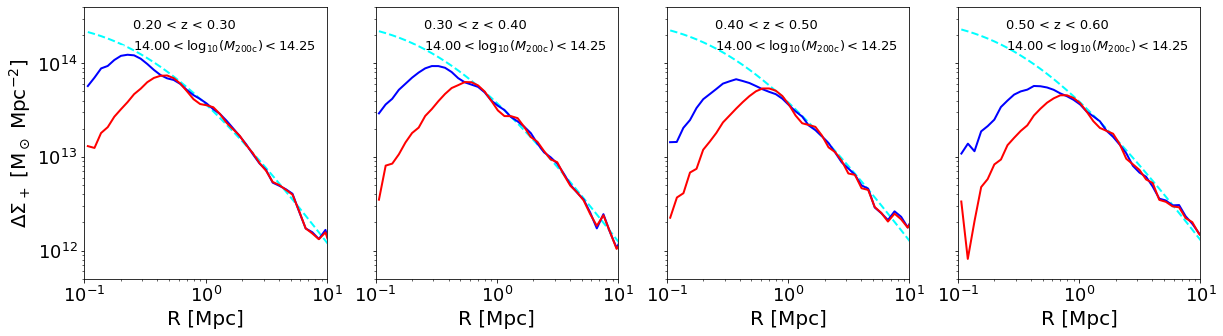

In [13]:
n_z_bin = len(Z_bin) - 4
n_m_bin = len(Mass_bin) - 1
print(n_z_bin, n_m_bin)
scale = 5
fig, axs = plt.subplots(n_m_bin,n_z_bin, figsize = (scale*n_z_bin,scale*n_m_bin))
plt.rcParams['axes.linewidth']= 2
for j, z_bin in enumerate(Z_bin):

    if j >= n_z_bin: continue
        
    for i, m_bin in enumerate(Mass_bin):

        if i >= n_m_bin: continue
            
        label_z = f'{z_bin[0]:.2f} < z < {z_bin[1]:.2f}'
        label_M = f'{np.log10(m_bin[0]):.2f}' + r'$ < \log_{10}(M_{\rm 200c}) < $' + f'{np.log10(m_bin[1]):.2f}'
        axs[ j].plot([], [], 'w', label = label_z)
        axs[ j].plot([], [], 'w', label = label_M)
        c = ['r','b']
        fmt = ['-', '--']
        marker = ['o', 's']
        markersize = [2,2]
        name = ['center cosmoDC2', 'center RedMapper']
        profile = [profile_stack_sky, profile_stack_cosmodc2]
        label = [ 'SkySim5000', 'cosmoDC2',]

        color = ['b','r']
        for g, profile_ in enumerate(profile):
            mask_z = (profile_['z_mean'] > z_bin[0])*(profile_['z_mean'] < z_bin[1])
            mask_m = (profile_['obs_mean'] > m_bin[0])*(profile_['obs_mean'] < m_bin[1])
            index = np.arange(len(profile_))
            prf_cut = profile_[index[mask_z*mask_m]][0]
            axs[j].plot(prf_cut['radius'], prf_cut['gt'], color[g], linewidth = 2)
            
        if i+j == 1000:
            
            axs[j].plot([],[], color[0], label = label[0],)
            axs[j].plot([],[], color[1], label = label[1],)
            axs[j].plot([],[], '--', c = 'cyan', label = 'fiducial',)
            axs[ j].legend(frameon = False, loc = 'lower left', fontsize = 13)
        else:
            axs[ j].legend(frameon = False, loc = 'upper right', fontsize = 13)
            
        c200 = conc._concentration(cosmo_ccl, prf_cut['obs_mean'], 1/(1 + prf_cut['z_mean']))   
        moo.set_mass(prf_cut['obs_mean']), moo.set_concentration(c200)
        yth = [moo.eval_excess_surface_density(prf_cut['radius'][o], prf_cut['z_mean']) for o in range(len(prf_cut['radius']))]
        axs[j].plot(prf_cut['radius'], yth, '--', linewidth = 2, color = 'cyan', zorder = 0)

        axs[ j].set_ylim(0.5*1e12, 4e14)
        axs[j].set_xlim(0.1, 10)
        axs[ j].set_xscale('log')
        axs[ j].set_yscale('log')
        axs[ j].set_xlabel('R [Mpc]', fontsize = 20)
        axs[j].set_ylabel(r'$\Delta\Sigma_+$ ' +'$[$' + r'${\rm M}$' + r'$_\odot\;$'+ r'${\rm Mpc}$'+r'$^{-2}$'r'$]$', fontsize = 20)
        axs[j].tick_params(axis='both', which = 'major', labelsize= 18, zorder = 0)
for ax in fig.get_axes():
    ax.label_outer()
#plt.savefig('/pbs/throng/lsst/users/cpayerne/ThesisAtCCin2p3/Images/profile_attenuation_SkySim_cosmoDC2.png', bbox_inches='tight', dpi=300)